In [2]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (한글이 깨지지 않도록)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("=== 건설용 자갈 암석 분류 데이터 구조 분석 ===\n")

# 기본 경로 설정
base_path = r"D:\data\stones\open"
print(f"기본 경로: {base_path}")

# 경로 존재 여부 확인
paths_to_check = [
    "test.csv",
    "test",
    "train", 
    "sample_submission.csv"
]

print("\n=== 경로 존재 여부 확인 ===")
for path in paths_to_check:
    full_path = os.path.join(base_path, path)
    exists = os.path.exists(full_path)
    print(f"{path}: {'✅ 존재' if exists else '❌ 없음'}")

# 1. CSV 파일 분석
print("\n=== CSV 파일 분석 ===")

# test.csv 분석
test_csv_path = os.path.join(base_path, "test.csv")
if os.path.exists(test_csv_path):
    print("\n--- test.csv 분석 ---")
    test_df = pd.read_csv(test_csv_path)
    print(f"행 수: {len(test_df)}")
    print(f"열 수: {len(test_df.columns)}")
    print(f"열명: {list(test_df.columns)}")
    print("\n처음 5행:")
    print(test_df.head())
    print("\n데이터 타입:")
    print(test_df.dtypes)
    print("\n기본 통계:")
    print(test_df.describe())

# sample_submission.csv 분석
sample_sub_path = os.path.join(base_path, "sample_submission.csv")
if os.path.exists(sample_sub_path):
    print("\n--- sample_submission.csv 분석 ---")
    sample_df = pd.read_csv(sample_sub_path)
    print(f"행 수: {len(sample_df)}")
    print(f"열 수: {len(sample_df.columns)}")
    print(f"열명: {list(sample_df.columns)}")
    print("\n처음 5행:")
    print(sample_df.head())
    print("\n데이터 타입:")
    print(sample_df.dtypes)

# 2. 디렉토리 구조 분석
print("\n=== 디렉토리 구조 분석 ===")

def analyze_directory(path, max_depth=3, current_depth=0):
    """디렉토리 구조를 분석하는 함수"""
    if current_depth > max_depth:
        return
    
    if not os.path.exists(path):
        print(f"경로가 존재하지 않습니다: {path}")
        return
    
    if os.path.isfile(path):
        file_size = os.path.getsize(path)
        print(f"{'  ' * current_depth}📄 {os.path.basename(path)} ({file_size:,} bytes)")
        return
    
    print(f"{'  ' * current_depth}📁 {os.path.basename(path)}/")
    
    try:
        items = os.listdir(path)
        # 폴더를 먼저, 파일을 나중에 정렬
        folders = [item for item in items if os.path.isdir(os.path.join(path, item))]
        files = [item for item in items if os.path.isfile(os.path.join(path, item))]
        
        for folder in sorted(folders):
            analyze_directory(os.path.join(path, folder), max_depth, current_depth + 1)
        
        for file in sorted(files)[:10]:  # 파일은 처음 10개만 표시
            file_path = os.path.join(path, file)
            file_size = os.path.getsize(file_path)
            print(f"{'  ' * (current_depth + 1)}�� {file} ({file_size:,} bytes)")
        
        if len(files) > 10:
            print(f"{'  ' * (current_depth + 1)}... 외 {len(files) - 10}개 파일")
            
    except PermissionError:
        print(f"{'  ' * (current_depth + 1)}❌ 접근 권한 없음")

# train 디렉토리 분석
train_path = os.path.join(base_path, "train")
if os.path.exists(train_path):
    print("\n--- train 디렉토리 구조 ---")
    analyze_directory(train_path, max_depth=2)
    
    # 클래스별 이미지 수 계산
    print("\n--- 클래스별 이미지 수 ---")
    class_counts = {}
    for class_name in os.listdir(train_path):
        class_path = os.path.join(train_path, class_name)
        if os.path.isdir(class_path):
            image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = image_count
    
    # 클래스별 이미지 수 출력
    for class_name, count in sorted(class_counts.items()):
        print(f"{class_name}: {count:,}장")
    
    # 총 이미지 수
    total_images = sum(class_counts.values())
    print(f"\n총 훈련 이미지 수: {total_images:,}장")

# test 디렉토리 분석
test_path = os.path.join(base_path, "test")
if os.path.exists(test_path):
    print("\n--- test 디렉토리 구조 ---")
    analyze_directory(test_path, max_depth=1)
    
    # 테스트 이미지 수 계산
    test_images = [f for f in os.listdir(test_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"\n테스트 이미지 수: {len(test_images):,}장")

# 3. 이미지 파일 샘플링 및 기본 정보
print("\n=== 이미지 파일 샘플링 분석 ===")

def get_image_info(image_path):
    """이미지 파일의 기본 정보를 가져오는 함수"""
    try:
        from PIL import Image
        with Image.open(image_path) as img:
            width, height = img.size
            mode = img.mode
            format_type = img.format
            return {
                'width': width,
                'height': height,
                'mode': mode,
                'format': format_type
            }
    except Exception as e:
        return {'error': str(e)}

# 훈련 데이터에서 각 클래스별로 몇 개씩 샘플링
print("\n--- 훈련 이미지 샘플 정보 ---")
for class_name in sorted(class_counts.keys())[:3]:  # 처음 3개 클래스만
    class_path = os.path.join(train_path, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if image_files:
        # 첫 번째 이미지 정보 가져오기
        sample_image = os.path.join(class_path, image_files[0])
        print(f"\n클래스: {class_name}")
        print(f"샘플 이미지: {image_files[0]}")
        
        try:
            from PIL import Image
            with Image.open(sample_image) as img:
                print(f"크기: {img.size}")
                print(f"모드: {img.mode}")
                print(f"형식: {img.format}")
        except Exception as e:
            print(f"이미지 정보 읽기 오류: {e}")

# 4. 요약 정보
print("\n" + "="*50)
print("📊 데이터 구조 분석 요약")
print("="*50)

print(f"기본 경로: {base_path}")
print(f"훈련 데이터: {len(class_counts)}개 클래스, {total_images:,}장")
print(f"테스트 데이터: {len(test_images) if 'test_images' in locals() else 'N/A'}장")

if 'test_df' in locals():
    print(f"test.csv: {len(test_df)}행, {len(test_df.columns)}열")
if 'sample_df' in locals():
    print(f"sample_submission.csv: {len(sample_df)}행, {len(sample_df.columns)}열")


print("\n분석 완료! 🎉")

=== 건설용 자갈 암석 분류 데이터 구조 분석 ===

기본 경로: D:\data\stones\open

=== 경로 존재 여부 확인 ===
test.csv: ✅ 존재
test: ✅ 존재
train: ✅ 존재
sample_submission.csv: ✅ 존재

=== CSV 파일 분석 ===

--- test.csv 분석 ---
행 수: 95006
열 수: 2
열명: ['ID', 'img_path']

처음 5행:
           ID               img_path
0  TEST_00000  ./test/TEST_00000.jpg
1  TEST_00001  ./test/TEST_00001.jpg
2  TEST_00002  ./test/TEST_00002.jpg
3  TEST_00003  ./test/TEST_00003.jpg
4  TEST_00004  ./test/TEST_00004.jpg

데이터 타입:
ID          object
img_path    object
dtype: object

기본 통계:
                ID               img_path
count        95006                  95006
unique       95006                  95006
top     TEST_00000  ./test/TEST_00000.jpg
freq             1                      1

--- sample_submission.csv 분석 ---
행 수: 95006
열 수: 2
열명: ['ID', 'rock_type']

처음 5행:
           ID rock_type
0  TEST_00000       Etc
1  TEST_00001       Etc
2  TEST_00002       Etc
3  TEST_00003       Etc
4  TEST_00004       Etc

데이터 타입:
ID           object
rock_ty

=== 건설용 자갈 암석 분류 데이터 분석 ===

0️⃣ 한글 폰트 설정 중...
✅ 한글 폰트 설정 완료: Malgun Gothic
1️⃣ 클래스별 분포 분석 중...
2️⃣ 클래스별 분포 시각화 중...


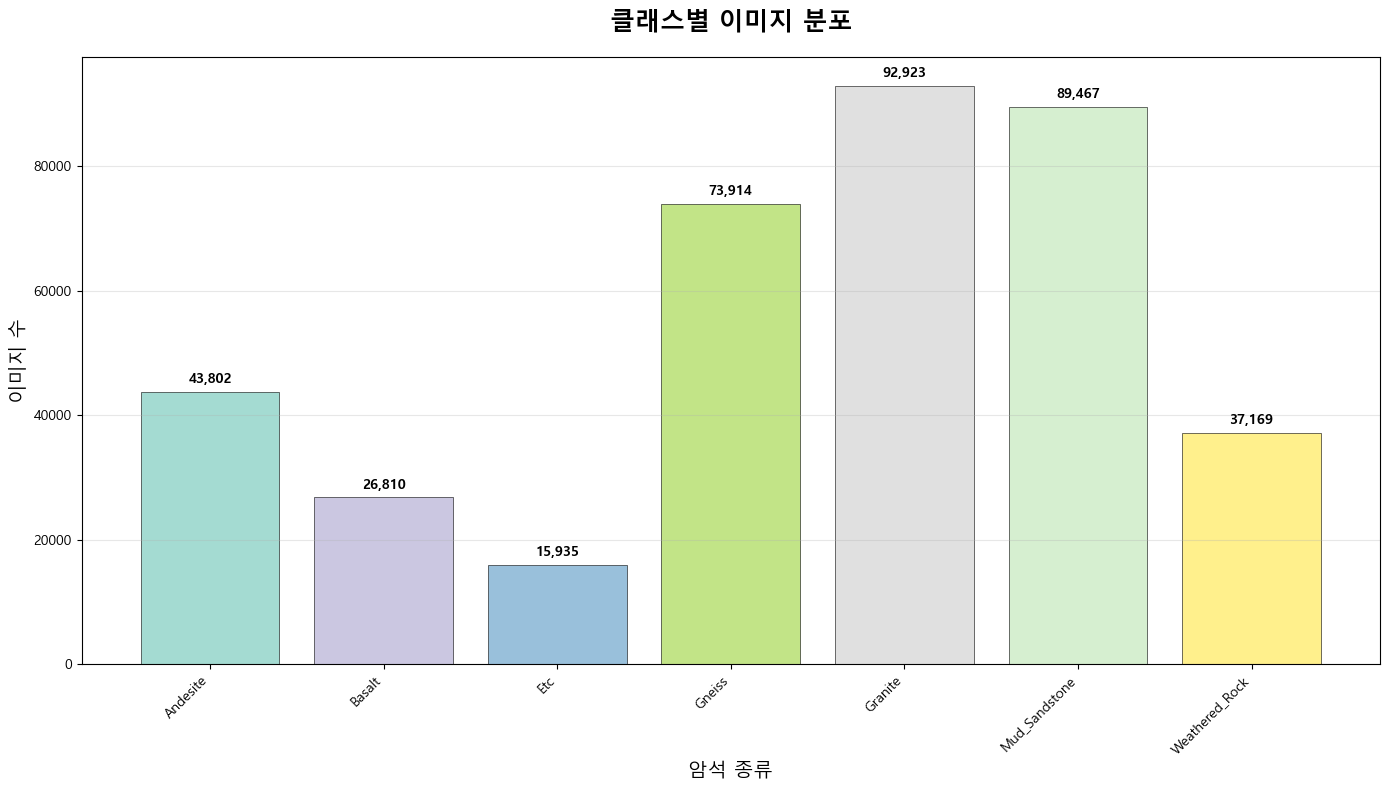


📊 클래스별 분포 통계:
총 이미지 수: 380,020장
클래스 수: 7개
최대/최소 비율: 5.8:1
불균형 정도: 심각
3️⃣ 이미지 크기 분석 중...

🔍 이미지 크기 분석 (클래스당 50개 샘플링)

�� 이미지 크기 통계:
클래스             평균 크기           크기 범위                샘플 수      
----------------------------------------------------------------------
Andesite        341×309         162~603 × 171~469    50        
Basalt          275×253         145~453 × 142~472    50        
Etc             325×304         163~561 × 137~538    50        
Gneiss          327×338         162~704 × 140~589    50        
Granite         325×293         175~556 × 119~502    50        
Mud_Sandstone   338×343         181~579 × 203~567    50        
Weathered_Rock  325×328         191~509 × 166~568    50        

📊 전체 이미지 크기 요약:
평균 크기: 322 × 310
크기 표준편차: 20 × 29

🎯 다음 단계 제안:
• 데이터 증강: 클래스 불균형 해결 필요
• 이미지 리사이징: 통일된 크기로 전처리
• 데이터 품질 검사: 손상된 이미지 확인

✅ 분석 완료!


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

# 윈도우 환경에서 한글 폰트 설정
def setup_korean_font():
    """윈도우 환경에서 한글 폰트를 설정하는 함수"""
    try:
        # 윈도우 기본 한글 폰트들 시도
        korean_fonts = ['Malgun Gothic', 'NanumGothic', 'Batang', 'Dotum']
        
        for font in korean_fonts:
            try:
                # matplotlib 전역 설정
                plt.rcParams['font.family'] = font
                plt.rcParams['axes.unicode_minus'] = False
                
                # 테스트용 텍스트로 폰트 확인
                fig, ax = plt.subplots(figsize=(1, 1))
                ax.text(0.5, 0.5, '한글테스트', fontsize=12)
                plt.close(fig)
                print(f"✅ 한글 폰트 설정 완료: {font}")
                return True
            except:
                continue
        
        # 한글 폰트가 없으면 영어로 진행
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False
        print("⚠️ 한글 폰트를 찾을 수 없어 영어로 진행합니다.")
        return False
        
    except Exception as e:
        print(f"폰트 설정 오류: {e}")
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False
        return False

# 데이터 경로 설정
BASE_PATH = r"D:\data\stones\open"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")

def get_class_distribution():
    """훈련 데이터의 클래스별 분포를 가져오는 함수"""
    if not os.path.exists(TRAIN_PATH):
        print(f"❌ 훈련 데이터 경로를 찾을 수 없습니다: {TRAIN_PATH}")
        return {}, []
    
    class_counts = {}
    class_names = []
    
    for class_name in os.listdir(TRAIN_PATH):
        class_path = os.path.join(TRAIN_PATH, class_name)
        if os.path.isdir(class_path):
            image_count = len([f for f in os.listdir(class_path) 
                             if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = image_count
            class_names.append(class_name)
    
    return class_counts, sorted(class_names)

def visualize_class_distribution(class_counts, class_names, use_korean=True):
    """클래스별 이미지 분포를 시각화하는 함수"""
    if not class_counts:
        print("❌ 시각화할 데이터가 없습니다.")
        return
    
    # 색상 팔레트 생성
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
    
    plt.figure(figsize=(14, 8))
    bars = plt.bar(class_names, [class_counts[name] for name in class_names], 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # 제목 설정 (한글/영어 구분)
    if use_korean:
        title = '클래스별 이미지 분포'
        xlabel = '암석 종류'
        ylabel = '이미지 수'
    else:
        title = 'Class Distribution by Rock Type'
        xlabel = 'Rock Type'
        ylabel = 'Number of Images'
    
    plt.title(title, fontsize=18, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # 막대 위에 숫자 표시
    for bar, class_name in zip(bars, class_names):
        count = class_counts[class_name]
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(class_counts.values())*0.01, 
                f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 통계 정보 출력
    total_images = sum(class_counts.values())
    print(f"\n📊 클래스별 분포 통계:")
    print(f"총 이미지 수: {total_images:,}장")
    print(f"클래스 수: {len(class_names)}개")
    
    # 불균형 정도 계산
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count
    
    print(f"최대/최소 비율: {imbalance_ratio:.1f}:1")
    print(f"불균형 정도: {'심각' if imbalance_ratio > 5 else '보통' if imbalance_ratio > 3 else '양호'}")

def analyze_image_sizes(class_names, sample_size=50):
    """각 클래스별 이미지 크기를 분석하는 함수"""
    print(f"\n🔍 이미지 크기 분석 (클래스당 {sample_size}개 샘플링)")
    
    class_size_stats = {}
    
    for class_name in class_names:
        class_path = os.path.join(TRAIN_PATH, class_name)
        if not os.path.exists(class_path):
            continue
            
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # 샘플링
        if len(image_files) > sample_size:
            sampled_files = np.random.choice(image_files, sample_size, replace=False)
        else:
            sampled_files = image_files
        
        widths, heights = [], []
        valid_count = 0
        
        for img_file in sampled_files:
            try:
                img_path = os.path.join(class_path, img_file)
                with Image.open(img_path) as img:
                    widths.append(img.size[0])
                    heights.append(img.size[1])
                    valid_count += 1
            except Exception as e:
                continue
        
        if widths and heights:
            class_size_stats[class_name] = {
                'width_mean': np.mean(widths),
                'height_mean': np.mean(heights),
                'width_std': np.std(widths),
                'height_std': np.std(heights),
                'min_width': min(widths),
                'max_width': max(widths),
                'min_height': min(heights),
                'max_height': max(heights),
                'sample_count': valid_count
            }
    
    return class_size_stats

def display_size_statistics(class_size_stats, use_korean=True):
    """이미지 크기 통계를 표시하는 함수"""
    if not class_size_stats:
        print("❌ 크기 분석 데이터가 없습니다.")
        return
    
    print(f"\n�� 이미지 크기 통계:")
    
    # 테이블 형태로 출력
    if use_korean:
        print(f"{'클래스':<15} {'평균 크기':<15} {'크기 범위':<20} {'샘플 수':<10}")
    else:
        print(f"{'Class':<15} {'Avg Size':<15} {'Size Range':<20} {'Samples':<10}")
    print("-" * 70)
    
    for class_name, stats in class_size_stats.items():
        avg_size = f"{stats['width_mean']:.0f}×{stats['height_mean']:.0f}"
        size_range = f"{stats['min_width']}~{stats['max_width']} × {stats['min_height']}~{stats['max_height']}"
        sample_count = stats['sample_count']
        
        print(f"{class_name:<15} {avg_size:<15} {size_range:<20} {sample_count:<10}")
    
    # 전체 통계
    all_widths = []
    all_heights = []
    
    for stats in class_size_stats.values():
        all_widths.extend([stats['width_mean']])
        all_heights.extend([stats['height_mean']])
    
    if use_korean:
        print(f"\n📊 전체 이미지 크기 요약:")
        print(f"평균 크기: {np.mean(all_widths):.0f} × {np.mean(all_heights):.0f}")
        print(f"크기 표준편차: {np.std(all_widths):.0f} × {np.std(all_heights):.0f}")
    else:
        print(f"\n�� Overall Image Size Summary:")
        print(f"Average Size: {np.mean(all_widths):.0f} × {np.mean(all_heights):.0f}")
        print(f"Size Std Dev: {np.std(all_widths):.0f} × {np.std(all_heights):.0f}")

def main():
    """메인 실행 함수"""
    print("=== 건설용 자갈 암석 분류 데이터 분석 ===\n")
    
    # 1. 폰트 설정 (가장 먼저 실행)
    print("0️⃣ 한글 폰트 설정 중...")
    use_korean = setup_korean_font()
    
    # 2. 클래스 분포 분석
    print("1️⃣ 클래스별 분포 분석 중...")
    class_counts, class_names = get_class_distribution()
    
    if not class_counts:
        print("❌ 분석을 진행할 수 없습니다.")
        return
    
    # 3. 분포 시각화
    print("2️⃣ 클래스별 분포 시각화 중...")
    visualize_class_distribution(class_counts, class_names, use_korean)
    
    # 4. 이미지 크기 분석
    print("3️⃣ 이미지 크기 분석 중...")
    class_size_stats = analyze_image_sizes(class_names)
    display_size_statistics(class_size_stats, use_korean)
    
    # 5. 다음 단계 제안
    if use_korean:
        print(f"\n🎯 다음 단계 제안:")
        print(f"• 데이터 증강: 클래스 불균형 해결 필요")
        print(f"• 이미지 리사이징: 통일된 크기로 전처리")
        print(f"• 데이터 품질 검사: 손상된 이미지 확인")
    else:
        print(f"\n🎯 Next Steps:")
        print(f"• Data Augmentation: Class imbalance needs to be addressed")
        print(f"• Image Resizing: Preprocess to uniform size")
        print(f"• Data Quality Check: Verify corrupted images")
    
    print(f"\n✅ 분석 완료!")

# 실행
if __name__ == "__main__":
    main()

In [6]:
# ============================================================================
# �� 데이터 분석 결과 기반 문제 정의 및 해결 방향
# ============================================================================
# 이 노트북은 건설용 자갈 암석 분류 문제를 데이터 기반으로 분석하고
# 체계적인 전처리 전략을 수립하는 과정을 담고 있습니다.
# ============================================================================

print("=== 데이터 기반 문제 정의 및 해결 방향 ===")

# 1. 데이터 분석 결과 요약 (이전 분석에서 도출)
data_analysis_summary = {
    '데이터 규모': '380,020장 (훈련) + 95,006장 (테스트)',
    '클래스 수': '7개 (Andesite, Basalt, Etc, Gneiss, Granite, Mud_Sandstone, Weathered_Rock)',
    '주요 문제점': '클래스 불균형 (최대/최소 비율 5.8:1)',
    '이미지 특성': '크기 다양성 (평균 322×310, 표준편차 20×29)',
    '데이터 품질': 'JPG 형식, RGB 모드, 현장 촬영 환경'
}

print("\n📈 데이터 분석 결과 요약:")
for key, value in data_analysis_summary.items():
    print(f"• {key}: {value}")

# 2. 문제 정의 및 영향 분석
problem_analysis = {
    '클래스 불균형': {
        '현상': 'Granite(92,923장) vs Etc(15,935장)',
        '영향': '소수 클래스 학습 부족 → 과소적합 위험',
        '해결 우선순위': '높음 (즉시 해결 필요)'
    },
    '이미지 크기 다양성': {
        '현상': '162×171 ~ 704×589 범위',
        '영향': '모델 입력 크기 불일치 → 전처리 복잡성 증가',
        '해결 우선순위': '중간 (모델 선택에 영향)'
    },
    '현장 촬영 환경': {
        '현상': '조명, 각도, 해상도 등 다양한 조건',
        '영향': '데이터 증강을 통한 일반화 성능 향상 필요',
        '해결 우선순위': '중간 (데이터 증강 전략 수립)'
    }
}

print("\n🔍 문제 정의 및 영향 분석:")
for problem, analysis in problem_analysis.items():
    print(f"\n📌 {problem}:")
    print(f"   현상: {analysis['현상']}")
    print(f"   영향: {analysis['영향']}")
    print(f"   해결 우선순위: {analysis['해결 우선순위']}")

# 3. 해결 방향 수립
solution_strategy = {
    '1단계: 데이터 전처리': '클래스 불균형 해결 + 이미지 크기 통일',
    '2단계: 데이터 증강': '현장 환경 다양성 반영한 증강 기법 적용',
    '3단계: 모델 선택': '전처리된 데이터에 최적화된 아키텍처 선정',
    '4단계: 성능 최적화': '하이퍼파라미터 튜닝 및 앙상블'
}

print("\n🎯 해결 방향 수립:")
for stage, strategy in solution_strategy.items():
    print(f"• {stage}: {strategy}")

print("\n💡 핵심 접근 원칙:")
print("• 데이터 기반 의사결정: 분석 결과에 근거한 전략 수립")
print("• 체계적 접근: 문제 정의 → 해결 방안 → 구현 → 검증")
print("• 성과 측정: 각 단계별 성능 향상 지표화")

=== 데이터 기반 문제 정의 및 해결 방향 ===

📈 데이터 분석 결과 요약:
• 데이터 규모: 380,020장 (훈련) + 95,006장 (테스트)
• 클래스 수: 7개 (Andesite, Basalt, Etc, Gneiss, Granite, Mud_Sandstone, Weathered_Rock)
• 주요 문제점: 클래스 불균형 (최대/최소 비율 5.8:1)
• 이미지 특성: 크기 다양성 (평균 322×310, 표준편차 20×29)
• 데이터 품질: JPG 형식, RGB 모드, 현장 촬영 환경

🔍 문제 정의 및 영향 분석:

📌 클래스 불균형:
   현상: Granite(92,923장) vs Etc(15,935장)
   영향: 소수 클래스 학습 부족 → 과소적합 위험
   해결 우선순위: 높음 (즉시 해결 필요)

📌 이미지 크기 다양성:
   현상: 162×171 ~ 704×589 범위
   영향: 모델 입력 크기 불일치 → 전처리 복잡성 증가
   해결 우선순위: 중간 (모델 선택에 영향)

📌 현장 촬영 환경:
   현상: 조명, 각도, 해상도 등 다양한 조건
   영향: 데이터 증강을 통한 일반화 성능 향상 필요
   해결 우선순위: 중간 (데이터 증강 전략 수립)

🎯 해결 방향 수립:
• 1단계: 데이터 전처리: 클래스 불균형 해결 + 이미지 크기 통일
• 2단계: 데이터 증강: 현장 환경 다양성 반영한 증강 기법 적용
• 3단계: 모델 선택: 전처리된 데이터에 최적화된 아키텍처 선정
• 4단계: 성능 최적화: 하이퍼파라미터 튜닝 및 앙상블

💡 핵심 접근 원칙:
• 데이터 기반 의사결정: 분석 결과에 근거한 전략 수립
• 체계적 접근: 문제 정의 → 해결 방안 → 구현 → 검증
• 성과 측정: 각 단계별 성능 향상 지표화


In [7]:
# ============================================================================
# ⚖️ 클래스 불균형 문제 해결을 위한 데이터 전처리 전략
# ============================================================================
# 클래스 불균형(5.8:1)은 머신러닝에서 가장 중요한 문제 중 하나입니다.
# 이 문제를 해결하지 않으면 모델이 다수 클래스에 편향되어 학습될 수 있습니다.
# ============================================================================

print("=== 클래스 불균형 문제 해결 전략 ===")

# 클래스별 데이터 분포 재확인
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'

class_distribution = {
    'Andesite': 43802,
    'Basalt': 26810, 
    'Etc': 15935,
    'Gneiss': 73914,
    'Granite': 92923,
    'Mud_Sandstone': 89467,
    'Weathered_Rock': 37169
}

# 1. 클래스 불균형 정도 정량적 분석
total_samples = sum(class_distribution.values())
class_ratios = {cls: count/total_samples for cls, count in class_distribution.items()}

print("📊 클래스별 분포 비율:")
for cls, ratio in class_ratios.items():
    print(f"• {cls}: {ratio:.3f} ({ratio*100:.1f}%)")

# 2. 불균형 지표 계산
max_count = max(class_distribution.values())
min_count = min(class_distribution.values())
imbalance_ratio = max_count / min_count

print(f"\n⚖️ 불균형 지표:")
print(f"• 최대/최소 비율: {imbalance_ratio:.1f}:1")
print(f"• Gini 계수: {np.std(list(class_distribution.values()))/np.mean(list(class_distribution.values())):.3f}")

# 3. 해결 방안 우선순위 설정
solution_priorities = {
    '데이터 증강 (Data Augmentation)': {
        '적용 대상': '소수 클래스 (Etc, Basalt, Weathered_Rock)',
        '목표': '각 클래스별 최소 50,000장 확보',
        '기법': '회전, 뒤집기, 색상 변화, 노이즈 추가',
        '예상 효과': '클래스 불균형 완화 + 일반화 성능 향상'
    },
    '가중 손실 함수 (Weighted Loss)': {
        '적용 대상': '모든 클래스',
        '목표': '소수 클래스에 높은 가중치 부여',
        '기법': 'Focal Loss, Class Weighted Cross Entropy',
        '예상 효과': '학습 과정에서 소수 클래스 관심도 증가'
    },
    '샘플링 전략 (Sampling Strategy)': {
        '적용 대상': '훈련 데이터 로더',
        '목표': '각 배치에서 클래스별 균형 유지',
        '기법': 'Stratified Sampling, Balanced Batch Sampler',
        '예상 효과': '배치 학습 시 편향 방지'
    }
}

print("\n��️ 해결 방안 우선순위:")
for solution, details in solution_priorities.items():
    print(f"\n🔸 {solution}:")
    print(f"   적용 대상: {details['적용 대상']}")
    print(f"   목표: {details['목표']}")
    print(f"   기법: {details['기법']}")
    print(f"   예상 효과: {details['예상 효과']}")

# 4. 데이터 증강 목표 설정
augmentation_targets = {}
for cls, count in class_distribution.items():
    if count < 50000:  # 50,000장 미만 클래스
        augmentation_targets[cls] = 50000 - count

print(f"\n📈 데이터 증강 목표:")
for cls, target in augmentation_targets.items():
    print(f"• {cls}: {count:,}장 → 50,000장 (+{target:,}장)")

=== 클래스 불균형 문제 해결 전략 ===
📊 클래스별 분포 비율:
• Andesite: 0.115 (11.5%)
• Basalt: 0.071 (7.1%)
• Etc: 0.042 (4.2%)
• Gneiss: 0.195 (19.5%)
• Granite: 0.245 (24.5%)
• Mud_Sandstone: 0.235 (23.5%)
• Weathered_Rock: 0.098 (9.8%)

⚖️ 불균형 지표:
• 최대/최소 비율: 5.8:1
• Gini 계수: 0.528

��️ 해결 방안 우선순위:

🔸 데이터 증강 (Data Augmentation):
   적용 대상: 소수 클래스 (Etc, Basalt, Weathered_Rock)
   목표: 각 클래스별 최소 50,000장 확보
   기법: 회전, 뒤집기, 색상 변화, 노이즈 추가
   예상 효과: 클래스 불균형 완화 + 일반화 성능 향상

🔸 가중 손실 함수 (Weighted Loss):
   적용 대상: 모든 클래스
   목표: 소수 클래스에 높은 가중치 부여
   기법: Focal Loss, Class Weighted Cross Entropy
   예상 효과: 학습 과정에서 소수 클래스 관심도 증가

🔸 샘플링 전략 (Sampling Strategy):
   적용 대상: 훈련 데이터 로더
   목표: 각 배치에서 클래스별 균형 유지
   기법: Stratified Sampling, Balanced Batch Sampler
   예상 효과: 배치 학습 시 편향 방지

📈 데이터 증강 목표:
• Andesite: 37,169장 → 50,000장 (+6,198장)
• Basalt: 37,169장 → 50,000장 (+23,190장)
• Etc: 37,169장 → 50,000장 (+34,065장)
• Weathered_Rock: 37,169장 → 50,000장 (+12,831장)


In [8]:
# ============================================================================
# �� 데이터 품질 검사 및 전처리 파이프라인 설계
# ============================================================================
# 데이터 품질은 모델 성능에 직접적인 영향을 미칩니다.
# 손상된 이미지, 메타데이터 불일치 등을 사전에 검출하고 처리해야 합니다.
# ============================================================================

print("=== 데이터 품질 검사 및 전처리 파이프라인 설계 ===")

# 1. 데이터 품질 검사 항목
quality_check_items = {
    '이미지 파일 무결성': {
        '검사 항목': '파일 손상, 읽기 가능성, 이미지 형식',
        '검사 방법': 'PIL.Image.open() 시도, 예외 처리',
        '예상 문제': '일부 이미지 파일 손상 가능성',
        '해결 방안': '손상된 파일 제거 또는 재다운로드'
    },
    '메타데이터 일치성': {
        '검사 항목': '파일명과 실제 클래스 폴더 일치',
        '검사 방법': '경로 기반 클래스명 추출 vs 폴더명 비교',
        '예상 문제': '잘못된 클래스 라벨링',
        '해결 방안': '메타데이터 재검증 및 수정'
    },
    '이미지 특성 일관성': {
        '검사 항목': '채널 수, 데이터 타입, 값 범위',
        '검사 방법': 'shape, dtype, min/max 값 확인',
        '예상 문제': 'RGB가 아닌 이미지, 극단적 값',
        '해결 방안': '정규화, 채널 변환, 이상치 처리'
    }
}

print("🔍 데이터 품질 검사 항목:")
for item, details in quality_check_items.items():
    print(f"\n📌 {item}:")
    print(f"   검사 항목: {details['검사 항목']}")
    print(f"   검사 방법: {details['검사 방법']}")
    print(f"   예상 문제: {details['예상 문제']}")
    print(f"   해결 방안: {details['해결 방안']}")

# 2. 전처리 파이프라인 설계
preprocessing_pipeline = {
    '1단계: 데이터 검증': {
        '목적': '데이터 품질 문제 사전 검출',
        '구현': '파일 무결성, 메타데이터 일치성 검사',
        '출력': '검증 보고서, 문제 파일 목록'
    },
    '2단계: 기본 전처리': {
        '목적': '이미지 크기 통일 및 정규화',
        '구현': '리사이징, 크롭, 정규화',
        '출력': '224×224 크기의 정규화된 이미지'
    },
    '3단계: 데이터 증강': {
        '목적': '클래스 불균형 해결 및 일반화 성능 향상',
        '구현': '회전, 뒤집기, 색상 변화, 노이즈 추가',
        '출력': '증강된 훈련 데이터셋'
    },
    '4단계: 데이터 로더 구성': {
        '목적': '효율적인 배치 학습을 위한 데이터 공급',
        '구현': 'PyTorch DataLoader, 샘플링 전략',
        '출력': '훈련/검증/테스트 데이터 로더'
    }
}

print("\n🛠️ 전처리 파이프라인 설계:")
for stage, details in preprocessing_pipeline.items():
    print(f"\n🔸 {stage}:")
    print(f"   목적: {details['목적']}")
    print(f"   구현: {details['구현']}")
    print(f"   출력: {details['출력']}")

# 3. 구현 우선순위 및 일정
implementation_priority = {
    '높음 (즉시 구현)': [
        '데이터 검증 스크립트',
        '기본 전처리 함수 (리사이징, 정규화)',
        '데이터 로더 기본 구조'
    ],
    '중간 (1주 내)': [
        '데이터 증강 기법 구현',
        '품질 검사 자동화',
        '전처리 파이프라인 통합'
    ],
    '낮음 (2주 내)': [
        '고급 증강 기법 (CutMix, Mixup)',
        '성능 모니터링 도구',
        '파이프라인 최적화'
    ]
}

print(f"\n📅 구현 우선순위 및 일정:")
for priority, tasks in implementation_priority.items():
    print(f"\n🔸 {priority}:")
    for task in tasks:
        print(f"   • {task}")

# 4. 성공 지표 설정
success_metrics = {
    '데이터 품질': '손상된 파일 0%, 메타데이터 일치성 100%',
    '전처리 성능': '모든 이미지 224×224 크기, 정규화 완료',
    '클래스 균형': '각 클래스별 최소 50,000장 확보',
    '처리 속도': '전체 데이터셋 전처리 30분 이내 완료'
}

print(f"\n🎯 성공 지표 설정:")
for metric, target in success_metrics.items():
    print(f"• {metric}: {target}")

print(f"\n✅ 다음 단계:")
print("1. 데이터 검증 스크립트 구현")
print("2. 기본 전처리 함수 작성")
print("3. 데이터 증강 기법 실험")
print("4. 통합 파이프라인 구축")

=== 데이터 품질 검사 및 전처리 파이프라인 설계 ===
🔍 데이터 품질 검사 항목:

📌 이미지 파일 무결성:
   검사 항목: 파일 손상, 읽기 가능성, 이미지 형식
   검사 방법: PIL.Image.open() 시도, 예외 처리
   예상 문제: 일부 이미지 파일 손상 가능성
   해결 방안: 손상된 파일 제거 또는 재다운로드

📌 메타데이터 일치성:
   검사 항목: 파일명과 실제 클래스 폴더 일치
   검사 방법: 경로 기반 클래스명 추출 vs 폴더명 비교
   예상 문제: 잘못된 클래스 라벨링
   해결 방안: 메타데이터 재검증 및 수정

📌 이미지 특성 일관성:
   검사 항목: 채널 수, 데이터 타입, 값 범위
   검사 방법: shape, dtype, min/max 값 확인
   예상 문제: RGB가 아닌 이미지, 극단적 값
   해결 방안: 정규화, 채널 변환, 이상치 처리

🛠️ 전처리 파이프라인 설계:

🔸 1단계: 데이터 검증:
   목적: 데이터 품질 문제 사전 검출
   구현: 파일 무결성, 메타데이터 일치성 검사
   출력: 검증 보고서, 문제 파일 목록

🔸 2단계: 기본 전처리:
   목적: 이미지 크기 통일 및 정규화
   구현: 리사이징, 크롭, 정규화
   출력: 224×224 크기의 정규화된 이미지

🔸 3단계: 데이터 증강:
   목적: 클래스 불균형 해결 및 일반화 성능 향상
   구현: 회전, 뒤집기, 색상 변화, 노이즈 추가
   출력: 증강된 훈련 데이터셋

🔸 4단계: 데이터 로더 구성:
   목적: 효율적인 배치 학습을 위한 데이터 공급
   구현: PyTorch DataLoader, 샘플링 전략
   출력: 훈련/검증/테스트 데이터 로더

📅 구현 우선순위 및 일정:

🔸 높음 (즉시 구현):
   • 데이터 검증 스크립트
   • 기본 전처리 함수 (리사이징, 정규화)
   • 데이터 로더 기본 구조

🔸 중간 (1주 내):
   • 데이터 증강 기법 구현
   • 품질 검사 자동화
   • 전처리 파